In [1]:
import os
os.chdir('team-lm/kaggle/input')

In [2]:
import pandas as pd
import numpy as np
import re
import itertools
import csv
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

pd.set_option('display.max_columns', 500)

train = pd.read_csv("train_2021.csv", dtype={"zip_code" : object})
test = pd.read_csv("test_2021.csv", dtype={"zip_code" : object})
# train_data = pd.read_csv("../data/raw_train_data.csv", dtype={"zip_code" : object})
# test_data = pd.read_csv("../data/raw_test_data.csv", dtype={"zip_code" : object})

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17998 entries, 0 to 17997
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   claim_number             17998 non-null  int64  
 1   age_of_driver            17998 non-null  int64  
 2   gender                   17998 non-null  object 
 3   marital_status           17993 non-null  float64
 4   safty_rating             17998 non-null  int64  
 5   annual_income            17998 non-null  int64  
 6   high_education_ind       17998 non-null  int64  
 7   address_change_ind       17998 non-null  int64  
 8   living_status            17998 non-null  object 
 9   zip_code                 17998 non-null  object 
 10  claim_date               17998 non-null  object 
 11  claim_day_of_week        17998 non-null  object 
 12  accident_site            17998 non-null  object 
 13  past_num_of_claims       17998 non-null  int64  
 14  witness_present_ind   

In [4]:
test.describe()

,claim_number,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight
count,12002.000000,12002.000000,12000.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,11914.000000,12002.000000,12002.000000,11988.000000,11999.000000,12002.000000,12002.000000
mean,15045.335111,43.525162,0.715167,73.702966,37331.504833,0.698134,0.576737,0.494918,0.238711,49.770122,0.601066,5016.502211,4.969331,22925.335594,22860.701764
std,8661.251912,12.201298,0.451354,15.378967,2926.069309,0.459087,0.494097,0.956002,0.426313,33.581191,0.489699,2257.041870,2.227267,12108.888412,12198.142508
min,2.000000,19.000000,0.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,471.363743,0.000000,2261.507903,2583.428985
25%,7532.250000,35.000000,0.000000,66.000000,35550.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,3367.182392,3.000000,14087.559950,13832.434587
50%,15055.500000,43.000000,1.000000,76.000000,37606.000000,1.000000,1.000000,0.000000,0.000000,50.000000,1.000000,4673.058955,5.000000,20642.029325,20508.293695
75%,22559.500000,51.000000,1.000000,85.000000,39313.000000,1.000000,1.000000,1.000000,0.000000,82.000000,1.000000,6295.292309,6.000000,29293.641235,29205.553660
max,29998.000000,278.000000,1.000000,100.000000,56275.000000,1.000000,1.000000,6.000000,1.000000,100.000000,1.000000,23903.366250,14.000000,106991.684500,101818.964200


It could be seen from the dataset summary that **age_of_driver** has values larger than 100, **annual_income** has a value of -1, and **fraud** has values that are -1. These values should be set as missing values.

In [5]:
train.isnull().sum()

claim_number                 0
age_of_driver                0
gender                       0
marital_status               5
safty_rating                 0
annual_income                0
high_education_ind           0
address_change_ind           0
living_status                0
zip_code                     0
claim_date                   0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        132
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout            17
age_of_vehicle               8
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
fraud                        0
dtype: int64

From the summary above, the dataset also has some missing values in  
**marital_stats,witness_present_ind,claim_est_payout,age_of_vehivle**

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

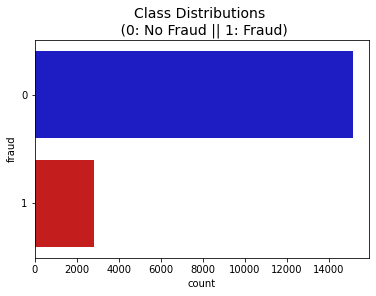

In [6]:
import matplotlib.pyplot as plt
colors = ["#0101DF", "#DF0101"]
sns.countplot(y='fraud', data=train, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [7]:
## fraud
train = train[train.fraud != -1]

## annual_income
train.loc[train.annual_income==-1, 'annual_income'] = np.nan
test.loc[test.annual_income==-1, 'annual_income'] = np.nan

## age_of_driver
train.loc[train.age_of_driver>100, 'age_of_driver'] = np.nan
test.loc[test.age_of_driver>100, 'age_of_driver'] = np.nan

## Encode Categorical Variables

In [8]:
# set claim_number as index:
train = train.set_index('claim_number')
test = test.set_index('claim_number')

In [9]:
train["gender"] = pd.Categorical(train["gender"])
train["living_status"] = pd.Categorical(train["living_status"])
train["marital_status"] = pd.Categorical(train["marital_status"])
train["high_education_ind"] = pd.Categorical(train["high_education_ind"])
train["address_change_ind"] = pd.Categorical(train["address_change_ind"])
train["zip_code"] = pd.Categorical(train["zip_code"])
train["witness_present_ind"] = pd.Categorical(train["witness_present_ind"])
train["policy_report_filed_ind"] = pd.Categorical(train["policy_report_filed_ind"])
train["fraud"] = pd.Categorical(train["fraud"])

test["gender"] = pd.Categorical(test["gender"])
test["living_status"] = pd.Categorical(test["living_status"])
test["marital_status"] = pd.Categorical(test["marital_status"])
test["high_education_ind"] = pd.Categorical(test["high_education_ind"])
test["address_change_ind"] = pd.Categorical(test["address_change_ind"])
test["zip_code"] = pd.Categorical(test["zip_code"])
test["witness_present_ind"] = pd.Categorical(test["witness_present_ind"])
test["policy_report_filed_ind"] = pd.Categorical(test["policy_report_filed_ind"])

In [10]:
### On the train data
train["claim_month"] = train['claim_date'].apply(
    lambda x: int(re.search("^(\d+)/", x).group(1)))
train["claim_day"] = train['claim_date'].apply(
    lambda x: int(re.search("/(\d+)/", x).group(1)))
train["claim_year"] = train['claim_date'].apply(
    lambda x: int(re.search("/(\d+)$", x).group(1)))
train.drop(["claim_date"], axis=1, inplace=True)

### On the test data
test["claim_month"] = test['claim_date'].apply(
    lambda x: int(re.search("^(\d+)/", x).group(1)))
test["claim_day"] = test['claim_date'].apply(
    lambda x: int(re.search("/(\d+)/", x).group(1)))
test["claim_year"] = test['claim_date'].apply(
    lambda x: int(re.search("/(\d+)$", x).group(1)))
test.drop(["claim_date"], axis=1, inplace=True)

In [11]:
with open("zip_code_database.csv", newline='') as csvfile:
    csv_reader = csv.DictReader(csvfile, delimiter=',')
    zip_to_state = {}
    for zip_data in csv_reader:
        zip_to_state[zip_data['zip']] = zip_data['state']
        
### assuming the '0' zip code is NaN (no such thing as a zip code of 0)   
zip_to_state[np.nan] = np.nan
zip_to_state['0'] = np.nan

### transform zip code to latitude, longitude, and state
state_train = train['zip_code'].apply(
    lambda x: zip_to_state[x])
state_train.name = 'state'

state_test = test['zip_code'].apply(
    lambda x: zip_to_state[x])
state_test.name = 'state'


### Add these new features to the data frame
train = pd.concat([train, state_train], axis=1)
train["state"] = pd.Categorical(train["state"])

test = pd.concat([test, state_test], axis=1)
test["state"] = pd.Categorical(test["state"])

### Drop zip code
train.drop(["zip_code"], axis=1, inplace=True)
test.drop(["zip_code"], axis=1, inplace=True)

## Imputation of Missing Values 
(Use mode and mean to impute)

In [12]:
train.dropna(inplace=True)
test.dropna(inplace=True)
print(train.shape)
print(test.shape)

(17796, 26)
(11862, 25)


## One-Hot Encoding of Categorical Variables

Encode categorical variables that have more than two categories using one hot encoding.  
Check that the same number of categories exist in both the training and testing data sets.

In [13]:
###encoding for TRAIN data set

# ordinal encoding for day of week
weekday_mapper = {"Sunday":1, "Monday":2, "Tuesday":3, "Wednesday":4, "Thursday":5,
                  "Friday":6, "Saturday":7}
train["claim_day_of_week"] = train["claim_day_of_week"].replace(weekday_mapper)
train.drop(["claim_day_of_week"], axis=1, inplace=True)

# one-hot encoding for site of gender
gender_dummies = pd.get_dummies(train['gender'], 
                                  prefix='gender', drop_first=True)
train = pd.concat([train, gender_dummies], axis=1)
train.drop(["gender"], axis=1, inplace=True)

# one-hot encoding for site of living status
living_dummies = pd.get_dummies(train['living_status'], 
                                  prefix='living_status', drop_first=True)
train = pd.concat([train, living_dummies], axis=1)
train.drop(["living_status"], axis=1, inplace=True)

# one-hot encoding for site of accident
accident_dummies = pd.get_dummies(train['accident_site'], 
                                  prefix='accident_site', drop_first=True)
train = pd.concat([train, accident_dummies], axis=1)
train.drop(["accident_site"], axis=1, inplace=True)

# one-hot encoding for channel
channel_dummies = pd.get_dummies(train['channel'], 
                                 prefix='channel', drop_first=True)
train = pd.concat([train, channel_dummies], axis=1)
train.drop(["channel"], axis=1, inplace=True)

# ordinal encoding for vehicle category
cat_mapper = {"Compact":1, "Medium":2, "Large":3}
train["vehicle_category"] = train["vehicle_category"].replace(cat_mapper)
train.drop(["vehicle_category"], axis=1, inplace=True)

# one-hot encoding for vehicle color
vehicle_color_dummies = pd.get_dummies(train['vehicle_color'], 
                                 prefix='vehicle_color', drop_first=True)
train = pd.concat([train, vehicle_color_dummies], axis=1)
train.drop(["vehicle_color"], axis=1, inplace=True)

# one-hot encoding for state
state_dummies = pd.get_dummies(train['state'],
                               prefix='state', drop_first=True)
train = pd.concat([train, state_dummies], axis=1)
train.drop(["state"], axis=1, inplace=True)



### encoding for TEST data set

# ordinal encoding for day of week
weekday_mapper = {"Sunday":1, "Monday":2, "Tuesday":3, "Wednesday":4, "Thursday":5,
                  "Friday":6, "Saturday":7}
test["claim_day_of_week"] = test["claim_day_of_week"].replace(weekday_mapper)
test.drop(["claim_day_of_week"], axis=1, inplace=True)

# one-hot encoding for site of gender
gender_dummies = pd.get_dummies(test['gender'], 
                                  prefix='gender', drop_first=True)
test = pd.concat([test, gender_dummies], axis=1)
test.drop(["gender"], axis=1, inplace=True)

# one-hot encoding for site of living status
living_dummies = pd.get_dummies(test['living_status'], 
                                  prefix='living_status', drop_first=True)
test = pd.concat([test, living_dummies], axis=1)
test.drop(["living_status"], axis=1, inplace=True)

# one-hot encoding for site of accident
accident_dummies = pd.get_dummies(test['accident_site'], 
                                  prefix='accident_site', drop_first=True)
test = pd.concat([test, accident_dummies], axis=1)
test.drop(["accident_site"], axis=1, inplace=True)

# one-hot encoding for channel
channel_dummies = pd.get_dummies(test['channel'], 
                                 prefix='channel', drop_first=True)
test = pd.concat([test, channel_dummies], axis=1)
test.drop(["channel"], axis=1, inplace=True)

# ordinal encoding for vehicle category
cat_mapper = {"Compact":1, "Medium":2, "Large":3}
test["vehicle_category"] = test["vehicle_category"].replace(cat_mapper)
test.drop(["vehicle_category"], axis=1, inplace=True)

# one-hot encoding for vehicle color
vehicle_color_dummies = pd.get_dummies(test['vehicle_color'], 
                                 prefix='vehicle_color', drop_first=True)
test = pd.concat([test, vehicle_color_dummies], axis=1)
test.drop(["vehicle_color"], axis=1, inplace=True)

# one-hot encoding for state
state_dummies = pd.get_dummies(test['state'],
                               prefix='state', drop_first=True)
test = pd.concat([test, state_dummies], axis=1)
test.drop(["state"], axis=1, inplace=True)

In [14]:
### clean up variable names by making them all lowercase with underscore separators.
train.columns = map(
    lambda s: s.lower().replace(' ', '_'), 
    train.columns)

test.columns = map(
    lambda s: s.lower().replace(' ', '_'), 
    test.columns)


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17796 entries, 1 to 30000
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age_of_driver              17796 non-null  float64 
 1   marital_status             17796 non-null  category
 2   safty_rating               17796 non-null  int64   
 3   annual_income              17796 non-null  float64 
 4   high_education_ind         17796 non-null  category
 5   address_change_ind         17796 non-null  category
 6   past_num_of_claims         17796 non-null  int64   
 7   witness_present_ind        17796 non-null  category
 8   liab_prct                  17796 non-null  int64   
 9   policy_report_filed_ind    17796 non-null  category
 10  claim_est_payout           17796 non-null  float64 
 11  age_of_vehicle             17796 non-null  float64 
 12  vehicle_price              17796 non-null  float64 
 13  vehicle_weight             1779

In [16]:
train.to_csv('encoded_train.csv')
test.to_csv('encoded_test.csv')